In [ ]:
from google.colab import files
import io
import pandas as pd
print("load sample trip data in time_stamps")
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['1001.csv']))

load sample trip data in time_stamps


Saving 1001.csv to 1001.csv


# Section I
#Feature Extraction : Demo to extract count and turns for a single trip file sample
### use feature_builder.py script to extract all featuresand create -> model_data_train_features.csv & model_data_test_features.csv. Use these two files in section II and III

# Creates 2 features
* Count of Turns
* Count of Stops
* markers on plot shows the number of turns/stops counted per file



In [ ]:
import math

# Function logic to count turns/stops into a dataframe
def count_turns_stops(df):
  try:
    deg=45
    bins=3
    df["present"]=df["heading_degrees"]
    df=df.apply(pd.to_numeric)
    df.fillna(0,inplace=True)
    df=df[list(df.columns)].astype(int)
    # Considering every event within 3 seconds to be same - taking (3)average and selecting every 3rd row
    df=df.rolling(bins).mean() 
    df = df.iloc[::bins, :]
    df=df.apply(pd.to_numeric)
    df.fillna(0,inplace=True)
    df=df[list(df.columns)].astype(int)
    # Considering every event within 3 seconds to be same
    df.fillna(0,inplace=True)
    #Left & right turns
    df['turn_count'] = ((df.present.shift(1) - df.present).abs() > deg) &  (df.present.shift(-1) == df.present)
    df['turn_count']|=((df.present.shift(-1) - df.present).abs() > deg) &  (df.present.shift(1) == df.present) 
    #peak turns
    df['turn_count']|=((df.present.shift(-1) - df.present).abs() > deg) &  ((df.present.shift(1) - df.present).abs() >deg)
    #count_stops
    df["stop_count"]=(df.speed_meters_per_second.shift(-1) == df.speed_meters_per_second) &  (df.speed_meters_per_second.shift(1) == df.speed_meters_per_second)
    #df.to_csv("f.csv")
    #files.download("f.csv")
    return len(df[df.turn_count==True]),len(df[df.speed_meters_per_second==True]),df
  except Exception as e:
    print(e)
    return 0,0,None
  
nturns,nstops,data2=count_turns_stops(data)
print(nturns,nstops)

33 4


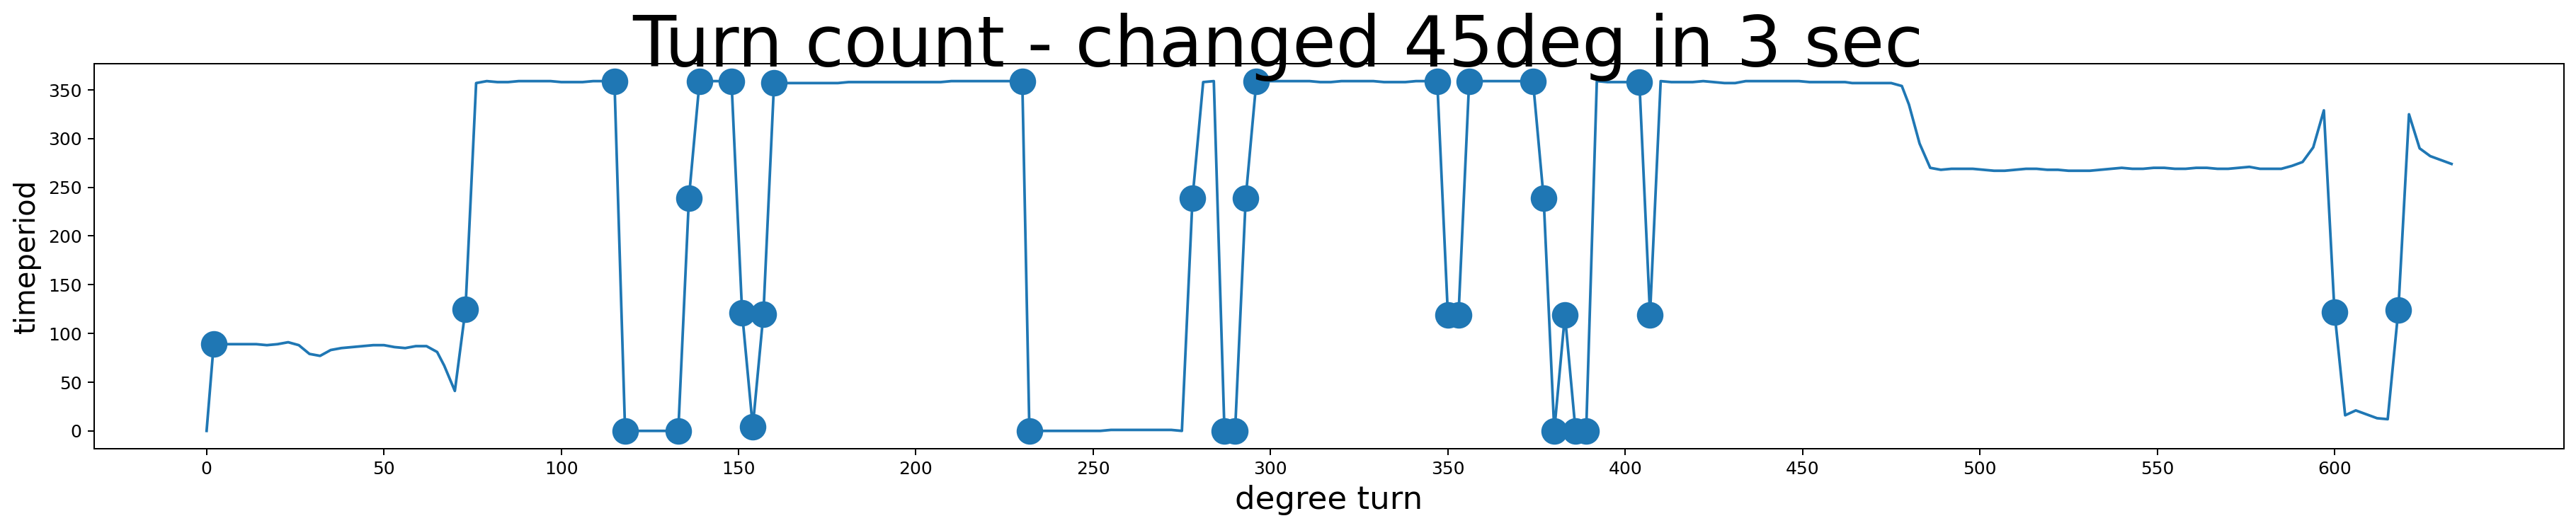

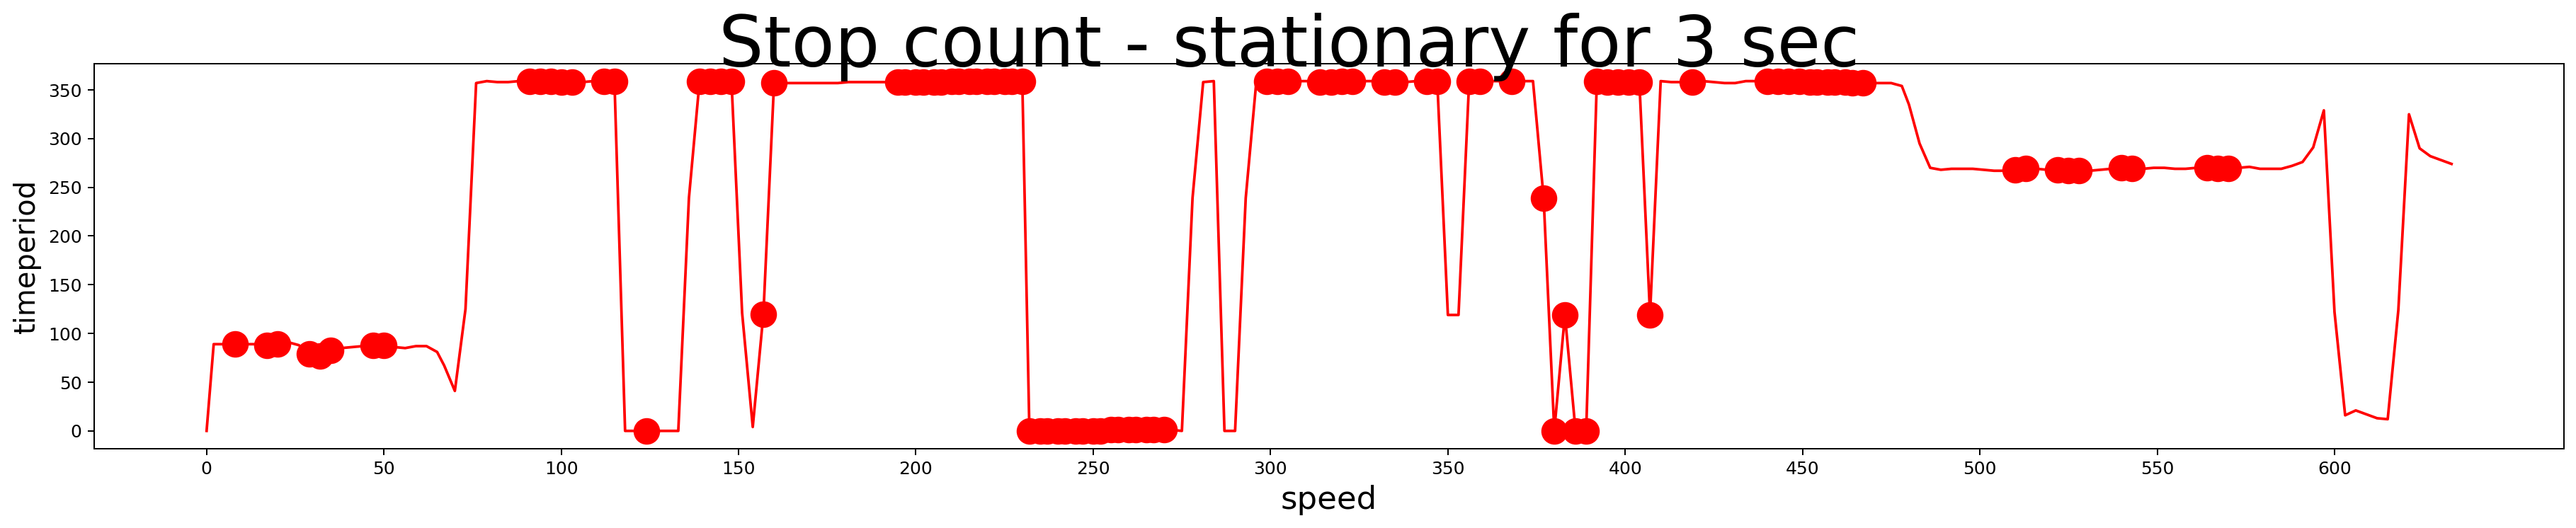

In [ ]:
import numpy as np
from matplotlib.pyplot import figure

# Plot the computed turns and stops with markers


markers_on = list(data2["turn_count"].values)
fig = plt.figure(num=None, figsize=(25, 4), dpi=180, facecolor='w', edgecolor='k')
fig.suptitle('Turn count - changed 45deg in 3 sec ', fontsize=40)
plt.xlabel('degree turn', fontsize=18)
plt.ylabel('timeperiod', fontsize=16)
plt.xticks(np.arange(min(data2['time_seconds']), max(data2['time_seconds'])+1, 50.0))
plt.plot(data2['time_seconds'],data2['heading_degrees'],markevery=markers_on, ls='-', ms=14, marker='o')
plt.show()

markers_on2 = list(data2["stop_count"].values)
fig = plt.figure(num=None, figsize=(25, 4), dpi=180, facecolor='w', edgecolor='k')
fig.suptitle('Stop count - stationary for 3 sec', fontsize=40)
plt.xlabel('speed', fontsize=18)
plt.ylabel('timeperiod', fontsize=16)
plt.xticks(np.arange(min(data2['time_seconds']), max(data2['time_seconds'])+1, 50.0))
plt.plot(data2['time_seconds'],data2['heading_degrees'],markevery=markers_on2, ls='-', ms=14, marker='o',color='r')
plt.show()

# Section II
# EDA

* High correlation observed between features(See correlation plot). they can be dropped.
* Data suffers from class imbalance 1:2.2 ratio.
* Data is mix of categorical and continious Features

Saving model_data_train_features.csv to model_data_train_features (7).csv


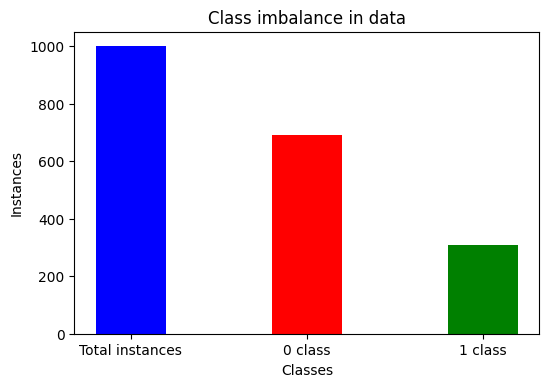

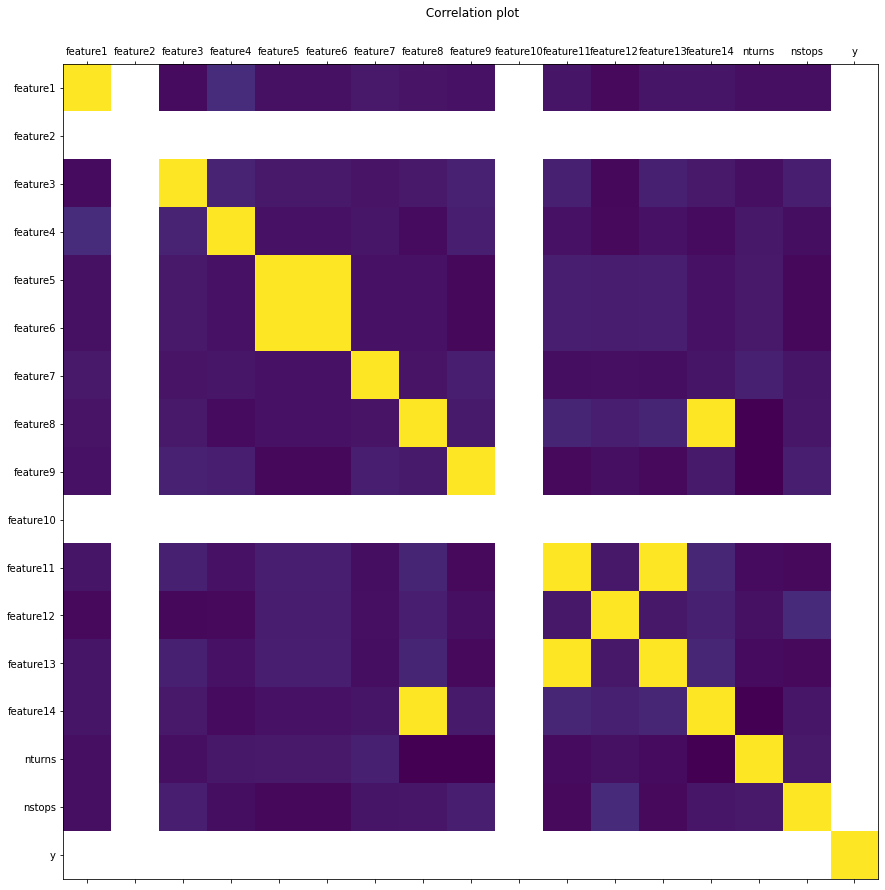

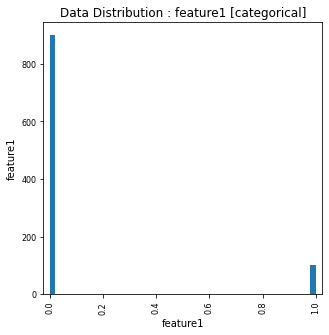

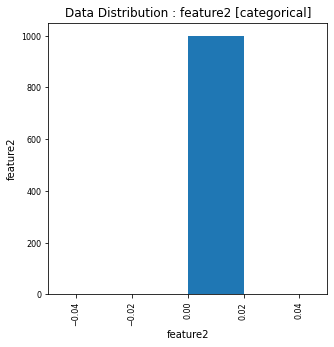

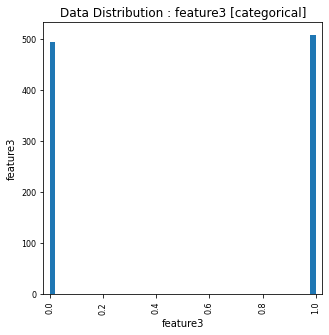

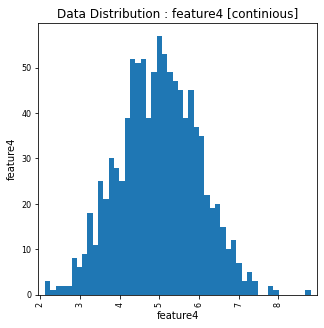

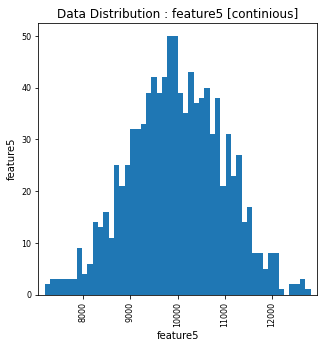

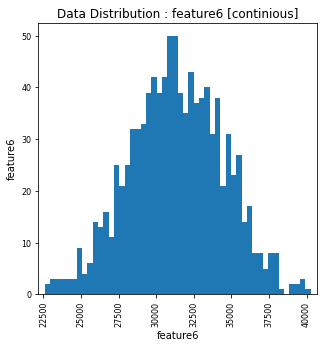

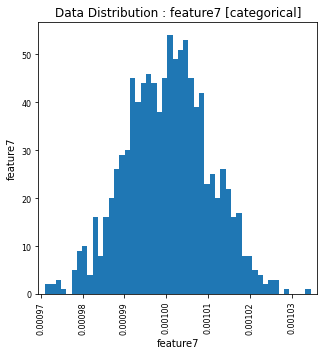

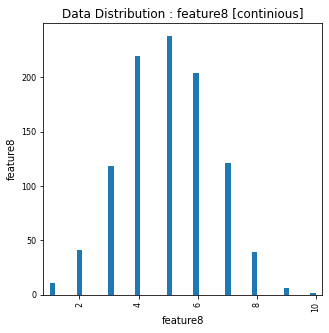

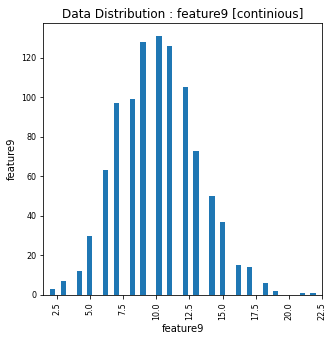

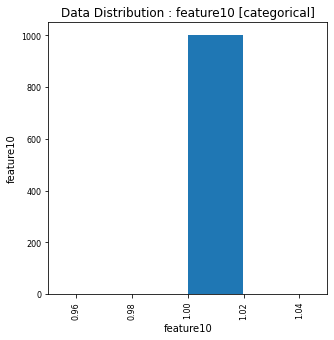

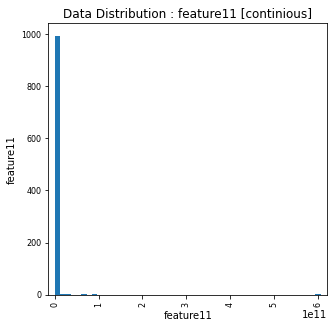

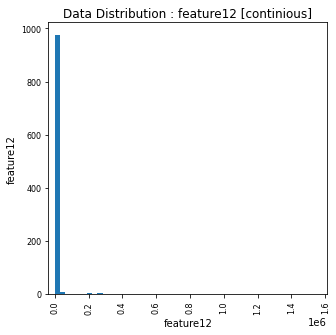

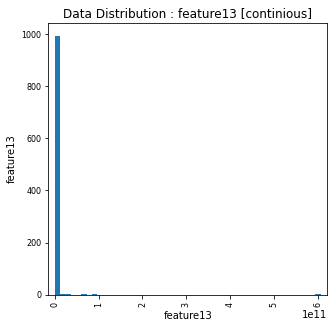

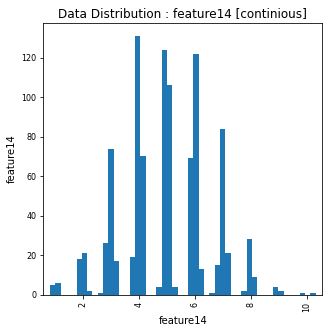

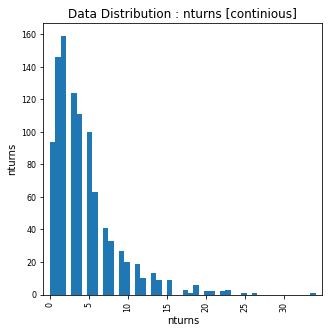

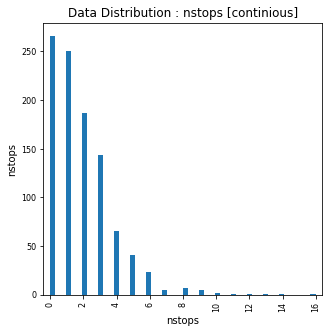

In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
import numpy as np
from google.colab import files
import io

print("load train data")
uploaded = files.upload()
processed_data = pd.read_csv(io.BytesIO(uploaded['model_data_train_features.csv']))

# Function to perform EDA
def data_eda_preprocess(data):
  data.drop(columns=['Unnamed: 0', 'filename'], inplace=True)

  val=[  len(data),len(data[data.y == 0]),  len(data[data.y == 1])]
  data.replace({False: 0, True: 1}, inplace=True)
  
  # Plot class imbalance
  plt.bar(["Total instances", "0 class","1 class"], val, color =['blue','red','green']  
        ,width = 0.4) 
  plt.xlabel("Classes") 
  plt.ylabel("Instances") 
  plt.title("Class imbalance in data") 
  plt.show() 

  # plot Correlation
  X = data[
        ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9',
         'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'nturns', 'nstops']]
  Y = data[["y"]]
  temp=pd.concat([X,Y],axis=0)
  corr = temp.corr()
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.matshow(corr)
  plt.xticks(range(len(corr.columns)), corr.columns);
  plt.yticks(range(len(corr.columns)), corr.columns);
  plt.title(" Correlation plot" )
  plt.show()

  # Plot Distribution of features
  for col in X.columns:
    rr = pd.plotting.scatter_matrix(X[[col]], c=Y, figsize=(5, 5), marker='o',
                                  hist_kwds={'bins': 50}, s=60, alpha=.8)
    typ=""
    try:
      z=len(X[col].astype(int).unique())
      if z <= 5:
        typ="categorical"
      else:
        typ="continious"
      plt.title("Data Distribution : "+str(col)+" ["+typ+"]" )
      plt.show()
    except:
      continue
data_eda_preprocess(processed_data)

# Section III
# Training & Evaluation

## Models used 

* Xgboost - Hyperparameters tuned with gridsearch(not shown) with stratified Kfold
* Random Forest Hyperparameters tuned with gridsearch(not shown) with stratified Kfold
* Untuned Random Forest classifier
* Random basleine classifier

## Explanation as to why these models/methods are used

* Tree based models are used as 
~~~
  * features are a mix of categorial, continious variables.
  * Tree based models do not need scaling
  * Tree based models have high degree of explainability and can rank importance of features.
  * Can model non linear reltionship as was this case discovered from EDA.
~~~
* More importance is given to f1 score than accuracy.
* Unbalanced data issue is handled by giving extra weight to minority class, proportionated stratified sampling & using f1 score/balanced accuracy for metrics
* Xgboost with tuned hyperparamters performs the best(seeing f1 score here)
* Feature Standardizing, PCA on features have minimal effect on results

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity as cs
import pandas as pd
import numpy as np
from google.colab import files
import io
import warnings
import logging
warnings.filterwarnings("ignore")

print("load train data")
uploaded = files.upload()
processed_data = pd.read_csv(io.BytesIO(uploaded['model_data_train_features.csv']))
res={}
res_test={}

# Function to build, evluate and test 4 models
def build_model(data):
    X = data[
        ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9',
         'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'nturns', 'nstops']]
    Y = data[["y"]]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # model 1 : Xgboost with HT/Skfold
    param = {
        'scale_pos_weight': 1.22,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
    }
    scoring = ['precision_macro', 'recall_macro','f1','balanced_accuracy']
    model_xgboost = XGBClassifier(learning_rate=0.001,
                          n_estimators=100,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=1,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=2.22,
                          seed=27,verbosity=0)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    results = cross_validate(model_xgboost, X_train, y_train, cv=kfold,verbose=0,scoring=scoring)
    model_xgboost.fit(X_train, y_train)
    res[str(type(model_xgboost).__name__)]=[]
    for i  in results:
        if i in ['test_f1']:
          
          res[str(type(model_xgboost).__name__)].append({"f1 score":np.mean(results[i])*100})
        
        if i in ['test_balanced_accuracy']:
             res[str(type(model_xgboost).__name__)].append({"balanced_accuracy":np.mean(results[i])*100}) 

    # Model 2 : Ranfom Forest with SKfold
    model_rf=RandomForestClassifier(verbose=0)
    kfold2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    results2 = cross_validate(model_rf, X_train, y_train, cv=kfold2,scoring=scoring)
    res[str(type(model_rf).__name__)+"Kfold"]=[]
    for i  in results2:
        if i in ['test_f1']:
          res[str(type(model_rf).__name__)+"Kfold"].append({"f1 score":np.mean(results2[i])*100})
        
        if i in ['test_balanced_accuracy']:
             res[str(type(model_rf).__name__)+"Kfold"].append({"balanced_accuracy":np.mean(results[i])*100})
    model_rf.fit(X_train, y_train) 

    # Model 3 with overfitting Random Forest
    model3=RandomForestClassifier(verbose=0,n_estimators=1000)
    model3.fit(X_train,y_train)
    pred=model3.predict(X_test)
    res[str(type(model3).__name__)]=[]
    res[str(type(model3).__name__)].append({"f1 score":f1_score(y_test,pred)*100})
    res[str(type(model3).__name__)].append({"balanced_accuracy":balanced_accuracy_score(y_test,pred)*100})

    model4 = RFE(model3, n_features_to_select=7, step=1)
    model4.fit(X_train, y_train)
    pred = model4.predict(X_test)
    res[str(type(model4).__name__)]=[]
    res[str(type(model4).__name__)].append({"f1 score":f1_score(y_test,pred)*100})
    res[str(type(model4).__name__)].append({"balanced_accuracy":balanced_accuracy_score(y_test,pred)*100})

    # Model4 Baseline Random model for comparison
    pred=y_test.sample(n=len(y_test), replace=True)
    res["random_baseline"]=[]
    res["random_baseline"].append({"f1 score":f1_score(y_test,pred)*100})
    res["random_baseline"].append({"balanced_accuracy":balanced_accuracy_score(y_test,pred)*100})

    # Test models and download result
    print("load test data")
    uploaded = files.upload()
    data2 = pd.read_csv(io.BytesIO(uploaded['model_data_test_features.csv']))

    X = data2[
        ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9',
         'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'nturns', 'nstops']]
   
    res_test["filename"]=data2["filename"]
    res_test["random_baseline"]=np.random.choice([0,1],len(X), replace=True)
    pred=model3.predict(X)
    res_test[str(type(model3).__name__)]=pred
    pred=model4.predict(X)
    res_test[str(type(model4).__name__)]=pred
    pred=model_rf.predict(X)
    res_test[str(type(model_rf).__name__)]=pred
    pred=model_xgboost.predict(X)
    res_test[str(type(model_xgboost).__name__)]=pred

    # print results
    print("-"*40,"Train Results","-"*40)
    for k in res:
      print("*"*80)
      print("\n",k,"\n",res[k])
    print("-"*40,"Test Results stored in res_test","-"*40)
    
build_model(processed_data)
output=pd.DataFrame.from_dict(res_test)
output.to_csv("predictions.csv")
files.download("predictions.csv")

load train data


Saving model_data_train_features.csv to model_data_train_features (6).csv
load test data


Saving model_data_test_features.csv to model_data_test_features (4).csv
---------------------------------------- Train Results ----------------------------------------
********************************************************************************

 XGBClassifier 
 [{'f1 score': 74.43746365244937}, {'balanced_accuracy': 81.44216894216895}]
********************************************************************************

 RandomForestClassifierKfold 
 [{'f1 score': 71.5467407620325}, {'balanced_accuracy': 81.44216894216895}]
********************************************************************************

 RandomForestClassifier 
 [{'f1 score': 74.50980392156863}, {'balanced_accuracy': 82.48440748440748}]
********************************************************************************

 RFE 
 [{'f1 score': 71.7948717948718}, {'balanced_accuracy': 80.94248094248094}]
********************************************************************************

 random_baseline 
 [{'f1 score': 20.731

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion

* Four models output are provided baseline random, Hypeparamter tuned XGboost with StratKfold, Random Forest with stratkfold, Random Forest
* further improvements can be done by using more samples
* improvement can be done by using multi modal input with late fusion. (BiLSTM/MLP). This architecture needs lot of data samples.
* I have give more importance to f1 score since I have no information whether to priortize minimizing FP or FN